In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import tensorflow as tf
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

import keras
import keras.utils as np_utils
from keras import layers
from keras import optimizers
from keras import losses
from keras.layers.core import Dense
from keras.layers.core import Dropout
from keras.layers.core import Activation
from tensorflow.keras.layers import BatchNormalization
from keras.models import Sequential

In [4]:
def one_hot_encoding(labels):
  flabels = pd.factorize(labels)[0]
  hot_labels = np.zeros((flabels.shape[0],np.max(flabels)+1))
  for i,label in enumerate(hot_labels):
      label[flabels[i]] = 1
  return hot_labels

def load_iris_data(iris_data):
  iris_data = pd.read_csv(iris_data,delim_whitespace = False,header=None)
  iris_data = iris_data.replace("?",np.NAN)
  iris_data = iris_data.sample(frac=1)
  iris_data = iris_data.values
  imputer = SimpleImputer(missing_values=np.NAN, strategy='mean')
  
  train_data = iris_data[:100,:4]
  test_data = iris_data[100:,:4]
  train_labels = one_hot_encoding(iris_data[:100,4])
  test_labels = one_hot_encoding(iris_data[100:,4])

  train_data = imputer.fit_transform(train_data)
  test_data = imputer.fit_transform(test_data)
  train_labels = imputer.fit_transform(train_labels)
  test_labels = imputer.fit_transform(test_labels)
  return (train_data,train_labels),(test_data,test_labels)

def load_balance_data(balance_data):
  balance_data = pd.read_csv(balance_data,delim_whitespace = False,header=None)
  balance_data = balance_data.replace("?",np.NAN)
  balance_data = balance_data.sample(frac=1)
  balance_data = balance_data.values
  imputer = SimpleImputer(missing_values=np.NAN, strategy='mean')

  train_data = balance_data[:400,1:]
  test_data = balance_data[400:,1:]
  train_labels = one_hot_encoding(balance_data[:400,0])
  test_labels = one_hot_encoding(balance_data[400:,0])

  train_data = imputer.fit_transform(train_data)
  test_data = imputer.fit_transform(test_data)
  train_labels = imputer.fit_transform(train_labels)
  test_labels = imputer.fit_transform(test_labels)
  return (train_data,train_labels),(test_data,test_labels)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adadelta.py:74: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adadelta, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


8/8 [==============================] - 0s 3ms/step - loss: 0.2222 - accuracy: 0.6667
SGD-MSE: [0.2222466766834259, 0.6666666865348816]
8/8 [==============================] - 0s 3ms/step - loss: 0.3337 - accuracy: 0.6667
SGD-MAE: [0.33374395966529846, 0.6666666865348816]
8/8 [==============================] - 0s 3ms/step - loss: 0.1053 - accuracy: 0.6667
SGD-logcosh: [0.10529427975416183, 0.6666666865348816]
8/8 [==============================] - 0s 3ms/step - loss: 0.2222 - accuracy: 0.6667
RMS-MSE: [0.2222224473953247, 0.6666666865348816]
8/8 [==============================] - 0s 5ms/step - loss: 0.3335 - accuracy: 0.6667
RMS-MAE: [0.33352693915367126, 0.6666666865348816]
8/8 [==============================] - 0s 3ms/step - loss: 0.1053 - accuracy: 0.6667
RMS-logcosh: [0.1052853912115097, 0.6666666865348816]
8/8 [==============================] - 0s 3ms/step - loss: 0.2228 - accuracy: 0.6667
AdaGrad-MSE: [0.22279006242752075, 0.6666666865348816]
8/8 [==============================] - 

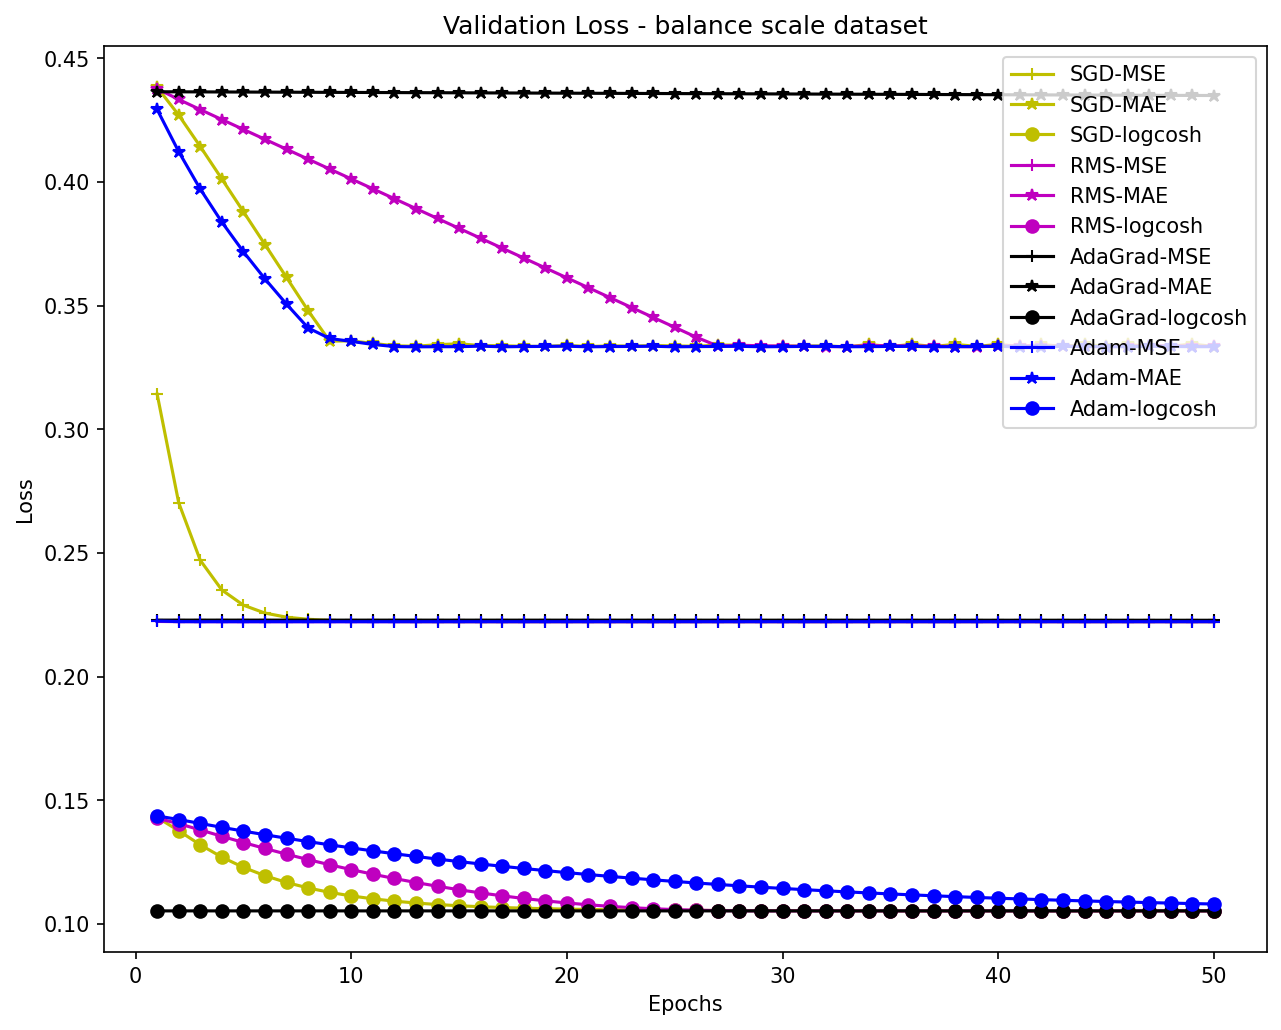

In [10]:
(train_data,train_labels),(test_data,test_labels) = load_balance_data("https://archive.ics.uci.edu/ml/machine-learning-databases/balance-scale/balance-scale.data")


model = Sequential()
model.add(layers.Dense(64,input_shape=(train_data.shape[1],)))
model.add(Activation('relu'))
model.add(layers.Dense(32))
model.add(Activation('relu'))
model.add(layers.Dense(16))
model.add(Activation('relu'))
model.add(layers.Dense(4))
model.add(Activation('relu'))
model.add(layers.Dense(1))

my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='/content/as3-loss_{loss:.3f}_val_acc{val_accuracy:.3f}.h5',
        monitor = 'val_accuracy',
        save_best_only = True
        ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor = 'loss',
        factor = 0.1,
        patience = 3,
        min_lr = 1e-5
    ),
]

plt.figure(num=None, figsize=(10, 8), dpi=150, facecolor='w', edgecolor='k')
hyperParameters = {'optimizer':[tf.keras.optimizers.SGD(lr=0.001,decay = 1e-5,momentum=0.9),
                       tf.keras.optimizers.RMSprop(lr=0.001,rho=0.9),
                       tf.keras.optimizers.Adadelta(lr=0.001, rho=0.9),
                       tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)],
          'losses':[losses.mean_squared_error,losses.mean_absolute_error,losses.logcosh]}

labels_losses = ['MSE','MAE','logcosh']
labels_optimizers = ['SGD','RMS','AdaGrad','Adam']
colors = {0: 'y',1: 'm',2: 'k',3: 'b'}
markers = {0: '+', 1: '*',2: 'o'}

for i, opt_param in enumerate(hyperParameters['optimizer']):
    for j, opt_loss in enumerate(hyperParameters['losses']):
        model.compile(loss = opt_loss,optimizer=opt_param,metrics=['accuracy'])
        result = model.fit(train_data, train_labels,epochs=50,batch_size=32,validation_split=0.1,verbose=0)
        val_loss_values = result.history['val_loss']
        epochs = range(1,len(val_loss_values)+1)
        plt.plot(epochs,val_loss_values,color=colors[i],marker=markers[j],label =  labels_optimizers[i]+ '-' +labels_losses[j])
        print("{}-{}: {}".format(labels_optimizers[i],labels_losses[j],model.evaluate(test_data,test_labels)))

title_main = 'Test Loss - balance scale dataset'
plt.title(title_main)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adadelta.py:74: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adadelta, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


8/8 [==============================] - 0s 3ms/step - loss: 0.2277 - accuracy: 0.6578
SGD-MSE: [0.22768983244895935, 0.6577778458595276]
8/8 [==============================] - 0s 3ms/step - loss: 0.3423 - accuracy: 0.6667
SGD-MAE: [0.3423033654689789, 0.6666666865348816]
8/8 [==============================] - 0s 3ms/step - loss: 0.1060 - accuracy: 0.6667
SGD-logcosh: [0.10603675246238708, 0.6666666865348816]
8/8 [==============================] - 0s 3ms/step - loss: 0.2223 - accuracy: 0.6667
RMS-MSE: [0.2223145216703415, 0.6666666865348816]
8/8 [==============================] - 0s 3ms/step - loss: 0.3367 - accuracy: 0.6667
RMS-MAE: [0.3366721570491791, 0.6666666865348816]
8/8 [==============================] - 0s 3ms/step - loss: 0.1053 - accuracy: 0.6667
RMS-logcosh: [0.1052977442741394, 0.6666666865348816]
8/8 [==============================] - 0s 3ms/step - loss: 0.2225 - accuracy: 0.6667
AdaGrad-MSE: [0.22254426777362823, 0.6666666865348816]
8/8 [==============================] - 0

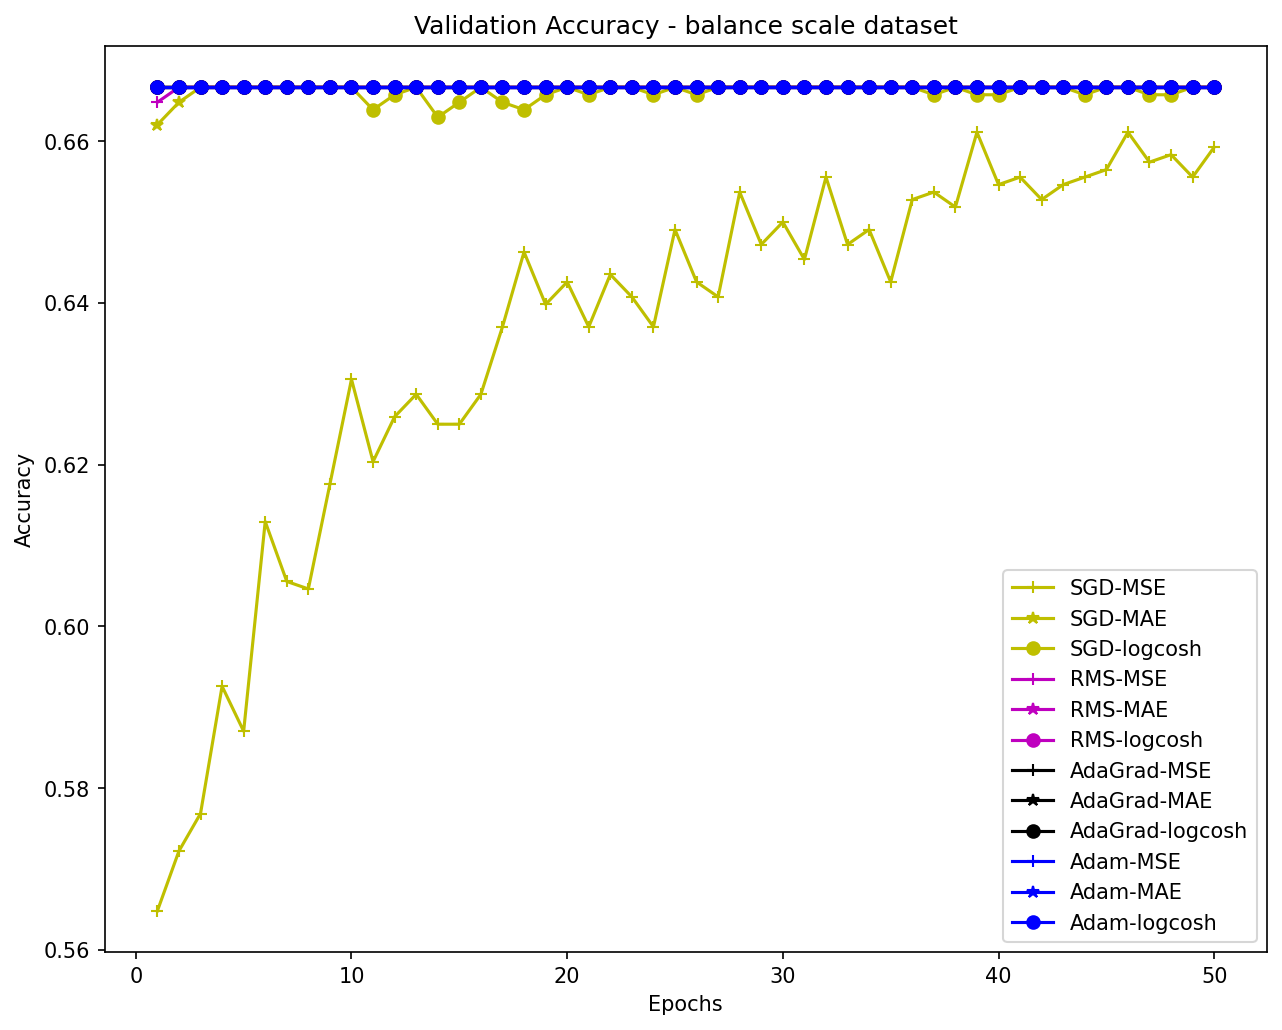

In [20]:
(train_data,train_labels),(test_data,test_labels) = load_balance_data("https://archive.ics.uci.edu/ml/machine-learning-databases/balance-scale/balance-scale.data")


model = Sequential()
model.add(layers.Dense(64,input_shape=(train_data.shape[1],)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(layers.Dense(32))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(layers.Dense(16))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(layers.Dense(4))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(layers.Dense(1))

my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='/content/as3-loss_{loss:.3f}_val_acc{val_accuracy:.3f}.h5',
        monitor = 'val_accuracy',
        save_best_only = True
        ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor = 'loss',
        factor = 0.1,
        patience = 3,
        min_lr = 1e-5
    ),
]

plt.figure(num=None, figsize=(10, 8), dpi=150, facecolor='w', edgecolor='k')
hyperParameters = {'optimizer':[tf.keras.optimizers.SGD(lr=0.001,decay = 1e-5,momentum=0.9),
                       tf.keras.optimizers.RMSprop(lr=0.001,rho=0.9),
                       tf.keras.optimizers.Adadelta(lr=0.001, rho=0.9),
                       tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)],
          'losses':[losses.mean_squared_error,losses.mean_absolute_error,losses.logcosh]}

labels_losses = ['MSE','MAE','logcosh']
labels_optimizers = ['SGD','RMS','AdaGrad','Adam']
colors = {0: 'y',1: 'm',2: 'k',3: 'b'}
markers = {0: '+', 1: '*',2: 'o'}

for i, opt_param in enumerate(hyperParameters['optimizer']):
    for j, opt_loss in enumerate(hyperParameters['losses']):
        model.compile(loss = opt_loss,optimizer=opt_param,metrics=['accuracy'])
        result = model.fit(train_data, train_labels,epochs=50,batch_size=32,validation_split=0.1,verbose=0)
        val_loss_values = result.history['accuracy']
        epochs = range(1,len(val_loss_values)+1)
        plt.plot(epochs,val_loss_values,color=colors[i],marker=markers[j],label =  labels_optimizers[i]+ '-' +labels_losses[j])
        print("{}-{}: {}".format(labels_optimizers[i],labels_losses[j],model.evaluate(test_data,test_labels)))

title_main = 'Test Accuracy - balance scale dataset'
plt.title(title_main)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adadelta.py:74: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adadelta, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


2/2 [==============================] - 0s 8ms/step - loss: 0.2947 - accuracy: 0.0000e+00
SGD-MSE: [0.2947145998477936, 0.0]
2/2 [==============================] - 0s 7ms/step - loss: 0.5634 - accuracy: 0.0000e+00
SGD-MAE: [0.5634230971336365, 0.0]
2/2 [==============================] - 0s 7ms/step - loss: 0.1808 - accuracy: 0.0000e+00
SGD-logcosh: [0.18083083629608154, 0.0]
2/2 [==============================] - 0s 7ms/step - loss: 0.6065 - accuracy: 0.0200
RMS-MSE: [0.6065270900726318, 0.019999999552965164]
2/2 [==============================] - 0s 8ms/step - loss: 0.6661 - accuracy: 0.0000e+00
RMS-MAE: [0.666110634803772, 0.0]
2/2 [==============================] - 0s 7ms/step - loss: 0.2833 - accuracy: 0.0000e+00
RMS-logcosh: [0.2832900583744049, 0.0]
2/2 [==============================] - 0s 7ms/step - loss: 0.6520 - accuracy: 0.0000e+00
AdaGrad-MSE: [0.652040421962738, 0.0]
2/2 [==============================] - 0s 7ms/step - loss: 0.6664 - accuracy: 0.0000e+00
AdaGrad-MAE: [0.666

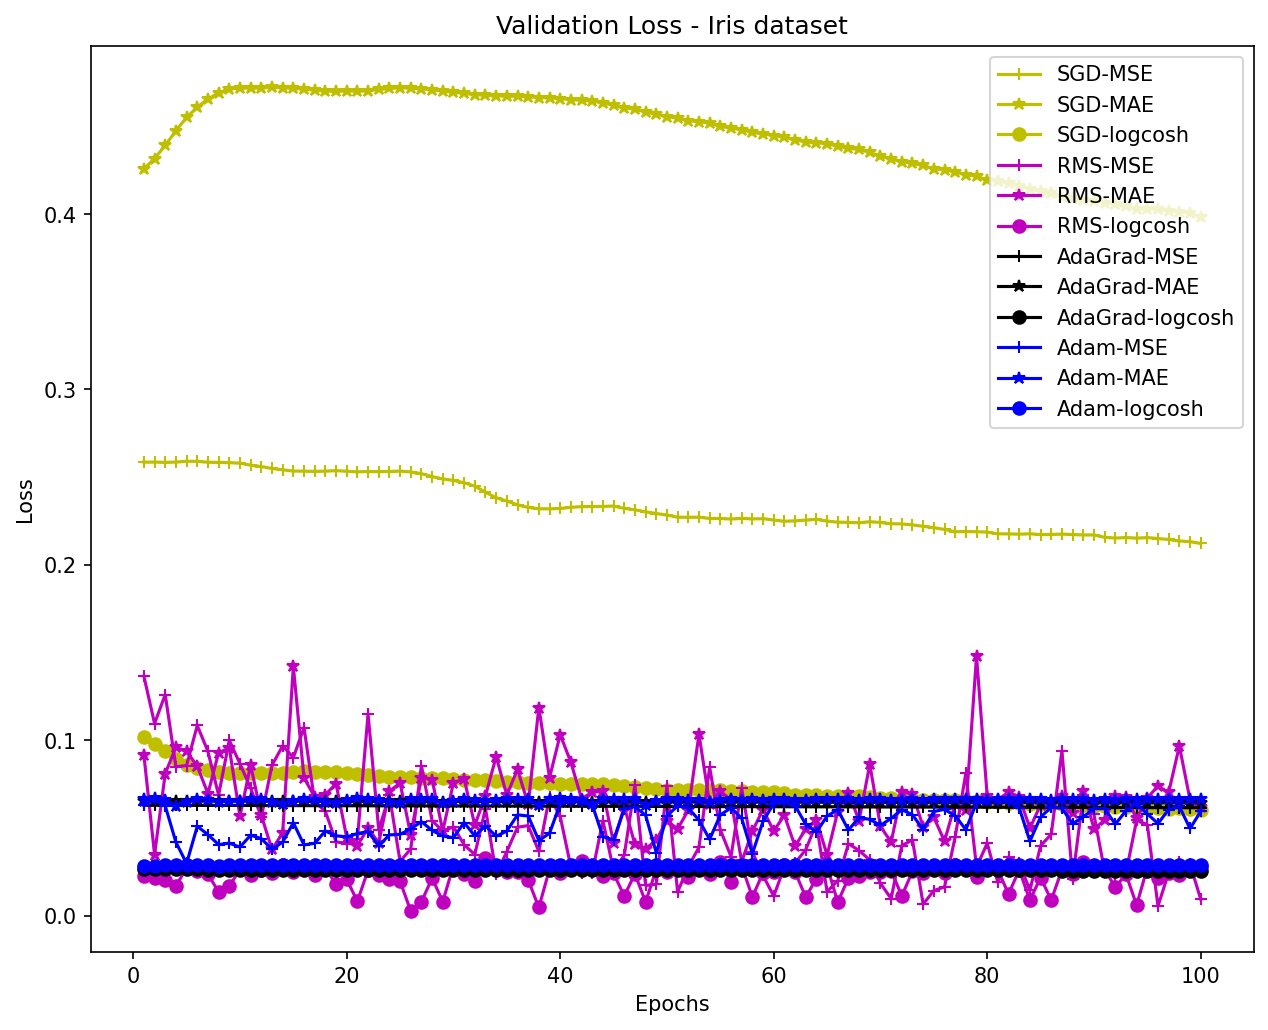

In [19]:
(train_data,train_labels),(test_data,test_labels) = load_iris_data("https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data")

model = Sequential()
model.add(layers.Dense(64,input_shape=(train_data.shape[1],)))
model.add(Activation('sigmoid'))
model.add(layers.Dense(32))
model.add(Activation('sigmoid'))
model.add(layers.Dense(16))
model.add(Activation('sigmoid'))
model.add(layers.Dense(8))
model.add(Activation('sigmoid'))
model.add(layers.Dense(3))
model.add(Activation('softmax'))

my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='/content/as3-loss_{loss:.3f}_val_acc{val_accuracy:.3f}.h5',
        monitor = 'val_accuracy',
        save_best_only = True
        ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor = 'loss',
        factor = 0.1,
        patience = 3,
        min_lr = 1e-5
    ),
]

plt.figure(num=None, figsize=(10, 8), dpi=150, facecolor='w', edgecolor='k')
hyperParameters = {'optimizer':[tf.keras.optimizers.SGD(lr=0.001,decay = 1e-5,momentum=0.9),
                       tf.keras.optimizers.RMSprop(lr=0.001,rho=0.9),
                       tf.keras.optimizers.Adadelta(lr=0.001, rho=0.9),
                       tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)],
          'losses':[losses.mean_squared_error,losses.mean_absolute_error,losses.logcosh]}
           # 'regularization':[tf.keras.regularizers.L2(l2=0.01), tf.keras.regularizers.L1(l1=0.01), tf.keras.regularizers.l1_l2(l1=0.01,l2=0.01)]}

labels_losses = ['MSE','MAE','logcosh']
labels_optimizers = ['SGD','RMS','AdaGrad','Adam']
# labels_regularizers = ['l2','l1','l1_l2']
colors = {0: 'y',1: 'm',2: 'k',3: 'b'}
markers = {0: '+', 1: '*',2: 'o'}

for i, opt_param in enumerate(hyperParameters['optimizer']):
    for j, opt_loss in enumerate(hyperParameters['losses']):
      #  for k, opt_rega in enumerate(hyperParameters['regularization']):
        model.compile(loss = opt_loss,optimizer=opt_param,metrics=['accuracy'])
        result = model.fit(train_data, train_labels,epochs=100,batch_size=32,validation_split=0.1,verbose=0)
        val_loss_values = result.history['val_loss']
        epochs = range(1,len(val_loss_values)+1)
        plt.plot(epochs,val_loss_values,color=colors[i],marker=markers[j],label =  labels_optimizers[i]+ '-' +labels_losses[j])
        print("{}-{}: {}".format(labels_optimizers[i],labels_losses[j],model.evaluate(test_data,test_labels)))

title_main = 'Test Loss - Iris dataset'
plt.title(title_main)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adadelta.py:74: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adadelta, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


2/2 [==============================] - 0s 8ms/step - loss: 0.9286 - accuracy: 0.5400
sgd-crossentropy: [0.9285586476325989, 0.5400000214576721]
2/2 [==============================] - 0s 9ms/step - loss: 0.7487 - accuracy: 0.5600
sgd-cat-hinge: [0.7487266063690186, 0.5600000023841858]
2/2 [==============================] - 0s 8ms/step - loss: 0.6579 - accuracy: 0.6800
sgd-kullback: [0.6579199433326721, 0.6800000071525574]
2/2 [==============================] - 0s 14ms/step - loss: 0.5497 - accuracy: 0.7800
rms-crossentropy: [0.5497125387191772, 0.7799999713897705]
2/2 [==============================] - 0s 8ms/step - loss: 0.5862 - accuracy: 0.7400
rms-cat-hinge: [0.5862470269203186, 0.7400000095367432]
2/2 [==============================] - 0s 8ms/step - loss: 0.4489 - accuracy: 0.8400
rms-kullback: [0.44890281558036804, 0.8399999737739563]
2/2 [==============================] - 0s 5ms/step - loss: 0.4639 - accuracy: 0.8000
adaGrad-crossentropy: [0.46385616064071655, 0.800000011920929]


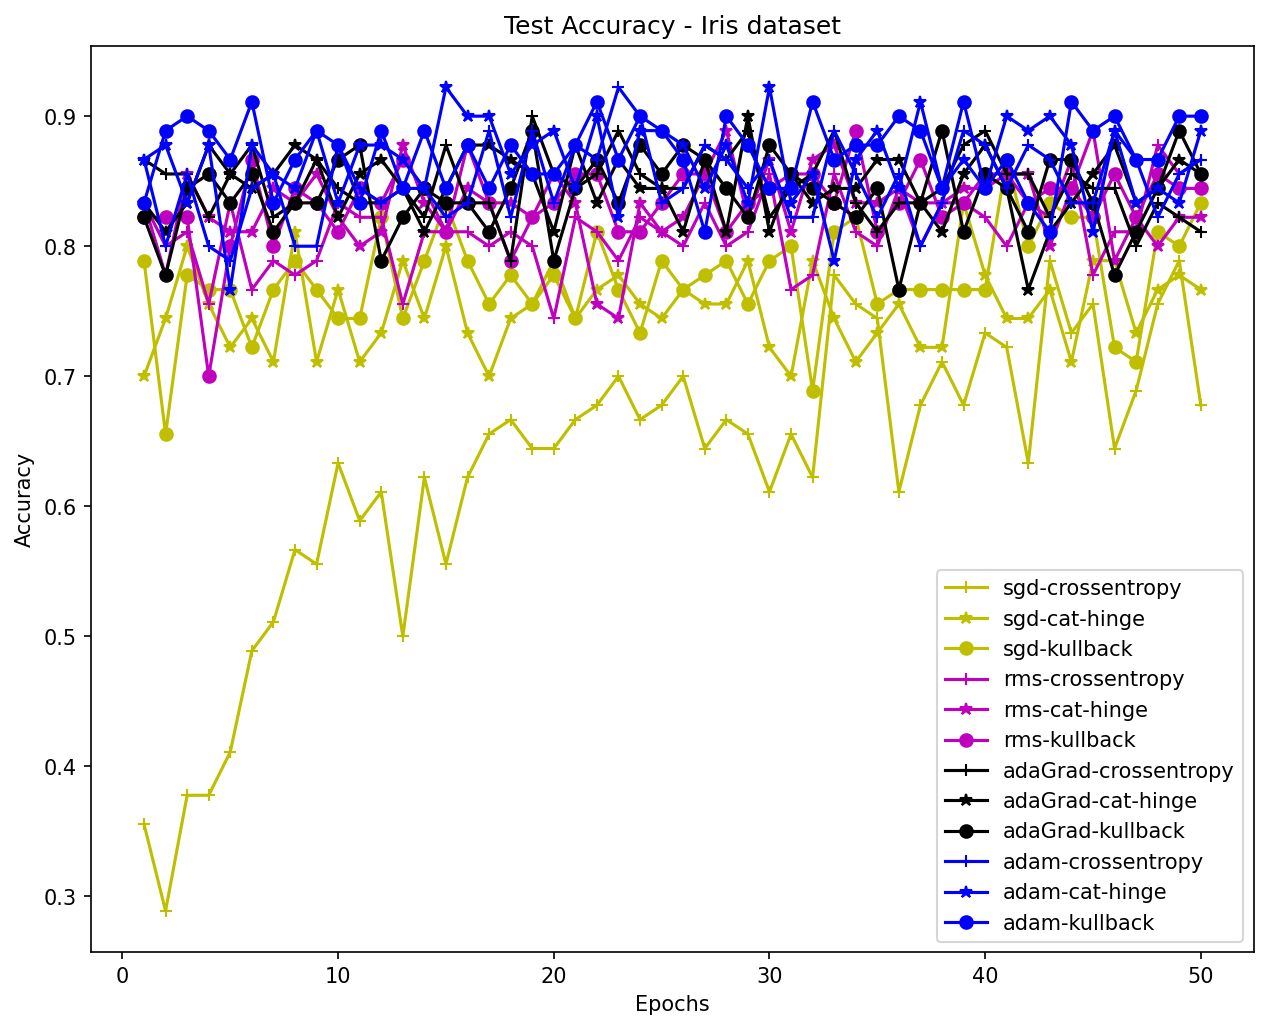

In [25]:
(train_data,train_labels),(test_data,test_labels) = load_iris_data("https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data")

model = Sequential()
model.add(layers.Dense(32,input_shape=(train_data.shape[1],)))
model.add(BatchNormalization())
model.add(Activation('sigmoid'))
model.add(Dropout(0.1))

model.add(layers.Dense(16))
model.add(BatchNormalization())
model.add(Activation('sigmoid'))
model.add(Dropout(0.1))

model.add(layers.Dense(3))
model.add(BatchNormalization())
model.add(Activation('softmax'))

my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='/content/as3-loss_{loss:.3f}_val_acc{val_accuracy:.3f}.h5',
        monitor = 'val_accuracy',
        save_best_only = True
        ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor = 'loss',
        factor = 0.1,
        patience = 3,
        min_lr = 1e-5
    ),
]
plt.figure(num=None, figsize=(10, 8), dpi=150, facecolor='w', edgecolor='k')
hyperParameters = {'optimizer':[tf.keras.optimizers.SGD(lr=0.001,decay = 1e-5,momentum=0.9),
                       tf.keras.optimizers.RMSprop(lr=0.001,rho=0.9),
                       tf.keras.optimizers.Adadelta(lr=0.001, rho=0.9),
                       tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)],
          'losses':['categorical_crossentropy','categorical_hinge','kullback_leibler_divergence']}
          # 'regularization':[tf.keras.regularizers.L2(l2=0.01), tf.keras.regularizers.L1(l1=0.01), tf.keras.regularizers.l1_l2(l1=0.01,l2=0.01)]}

track = []
labels_losses = ['crossentropy','cat-hinge','kullback']
labels_optimizers = ['sgd','rms','adaGrad','adam']
# labels_regularizers = ['l2','l1','l1_l2']
colors = {0: 'y',1: 'm',2: 'k',3: 'b'}
markers = {0: '+', 1: '*',2: 'o'}

for i, opt_param in enumerate(hyperParameters['optimizer']):
    for j, opt_loss in enumerate(hyperParameters['losses']):
      #  for k, opt_rega in enumerate(hyperParameters['regularization']):
        model.compile(loss = opt_loss,optimizer=opt_param,metrics=['accuracy'])
        result = model.fit(train_data, train_labels,epochs=50,batch_size=32,validation_split=0.1,verbose=False)
        track.append(model)
        val_acc_values = result.history['accuracy']
        epochs = range(1,len(val_acc_values)+1)
        plt.plot(epochs,val_acc_values,color=colors[i],marker=markers[j],label =  labels_optimizers[i]+ '-' +labels_losses[j])#+'-'+labels_regularizers[k])
        print("{}-{}: {}".format(labels_optimizers[i],labels_losses[j],model.evaluate(test_data,test_labels)))

title_main = 'Test Accuracy - Iris dataset'
plt.title(title_main)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [14]:
pred =  np.array([model.predict(test_data) for model in track])
sum_pred = np.sum(pred,axis=0)
max_sum_pred = np.argmax(sum_pred,axis=1)
print("Ensemble Classification Accuracy: {}".format(accuracy_score(np.argmax(test_labels,axis=1),result)))

Ensemble Classification Accuracy: 0.94
